In [1]:
"""
"""

'\n'

In [2]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import gzip as gz
from my_script import genome_annotations, utils
import dask.dataframe as dd
import importlib
importlib.reload(utils)
importlib.reload(genome_annotations)

<module 'my_script.genome_annotations' from '/scratch/dyl3pc/.tools/my_scripts/my_script/genome_annotations.py'>

# eQTL

In [2]:
CAD_coloc = pd.read_csv('/scratch/dyl3pc/fastqtl/scripts/plots/data/CAD_coloc_eQTL.csv')
gene_name_to_id_dict = genome_annotations.get_gene_name(reverse=True)
CAD_coloc['gene_id'] = CAD_coloc['Gene Symbol'].apply(lambda e: gene_name_to_id_dict[e])
CAD_coloc['gene_id_SNP'] = CAD_coloc.apply(lambda e: f"{e['gene_id']}_{e['SNP']}", axis=1)
CAD_coloc_WithFBS_gene_id_SNP = set(CAD_coloc[CAD_coloc['Phenotype'] == 'Proliferative']['gene_id_SNP'])
CAD_coloc_WithoutFBS_gene_id_SNP = set(CAD_coloc[CAD_coloc['Phenotype'] == 'Quiescent ']['gene_id_SNP'])

In [127]:
df1_file_name = "/scratch/dyl3pc/fastqtl/data/eQTL/WithFBS/cis_QTL/best_num_covariates/allpairs_anno.txt.gz"
df2_file_name = "/scratch/dyl3pc/fastqtl/data/eQTL/WithoutFBS/cis_QTL/best_num_covariates/allpairs_anno.txt.gz"
save_location = '/scratch/dyl3pc/fastqtl/scripts/plots/images/manhattan_CAD_coloc_eQTL_{}.svg'

In [4]:
def filter_WithFBS_filter_funct(values_dict):
    return f"{values_dict['phenotype_id']}_{values_dict['variant_id']}" in CAD_coloc_WithFBS_gene_id_SNP
def filter_WithoutFBS_filter_funct(values_dict):
    return f"{values_dict['phenotype_id']}_{values_dict['variant_id']}" in CAD_coloc_WithoutFBS_gene_id_SNP
df = utils.read_large_csv(df1_file_name, filter_WithFBS_filter_funct, sep='\t')
df2 = utils.read_large_csv(df2_file_name, filter_WithoutFBS_filter_funct, sep='\t')
df['Condition'] = 'Proliferative'
df2['Condition'] = 'Quiescent'
df = df.append(df2)

In [5]:
GWAS_variant_risk_allele_dict = utils.get_GWAS_variant_risk_allele_dict('/scratch/dyl3pc/fastqtl/data/other_studies/CAD_GWAS_64/grch38_cleaned.sumstats')

In [6]:
CAD_coloc

,Gene Symbol,SNP,Approach,Phenotype,gene_id,gene_id_SNP
0,CETP,rs1800775,COLOC,Proliferative,ENSG00000087237.12,ENSG00000087237.12_rs1800775
1,CTSK,rs12568757,COLOC,Proliferative,ENSG00000143387.13,ENSG00000143387.13_rs12568757
2,MARCH2,rs35562870,COLOC,Proliferative,ENSG00000099785.10,ENSG00000099785.10_rs35562870
3,STAT6,rs10747776,COLOC,Proliferative,ENSG00000166888.12,ENSG00000166888.12_rs10747776
4,TMEM106B,rs6460902,COLOC,Proliferative,ENSG00000106460.19,ENSG00000106460.19_rs6460902
...,...,...,...,...,...,...
197,NEK9,rs1043674,SMR,Proliferative,ENSG00000119638.13,ENSG00000119638.13_rs1043674
198,NEK9,rs2300601,LD,Quiescent,ENSG00000119638.13,ENSG00000119638.13_rs2300601
199,NEK9,rs2300601,SMR,Quiescent,ENSG00000119638.13,ENSG00000119638.13_rs2300601
200,ATP5MC1,rs4794006,SMR,Proliferative,ENSG00000159199.14,ENSG00000159199.14_rs4794006


In [7]:
df['GWAS_risk_allele'] = df['variant_id'].apply(lambda e: GWAS_variant_risk_allele_dict[e] if e in GWAS_variant_risk_allele_dict else "")

In [8]:
df = df[df['GWAS_risk_allele'] != '']

In [9]:
chr_lengths = genome_annotations.get_chr_lengths()

In [10]:
def get_increase_decrease_with_risk_allele(s):
    gwas_risk_allele = s['GWAS_risk_allele']
    eqtl_alt = s['alt']
    slope = s['slope']
    if eqtl_alt == gwas_risk_allele:
        if slope >= 0:
            return "Increased Expression with Risk Allele"
        else:
            return "Decreased Expression with Risk Allele"
    else:
        if slope >= 0:
            return "Decreased Expression with Risk Allele"
        else:
            return "Increased Expression with Risk Allele"
df['increase_decrease_risk_allele'] = df.apply(get_increase_decrease_with_risk_allele, axis = 1)

In [11]:
df1 = df[df['increase_decrease_risk_allele'] == "Decreased Expression with Risk Allele"]
df2 = df[df['increase_decrease_risk_allele'] == "Increased Expression with Risk Allele"]

In [12]:
def make_plot(df, title):
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (15,10)
    plt.rcParams["axes.titlesize"] = 35
    plt.rcParams["axes.labelsize"] = 30
    plt.rcParams["xtick.labelsize"] = 20
    plt.rcParams["ytick.labelsize"] = 20
    plt.rcParams["lines.markersize"] = 5
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['legend.fontsize'] = 14

    quiescent_color = "#36648b"
    proliferative_color = "#cd5555"

    chr_lengths = genome_annotations.get_chr_lengths()
    df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
    def get_padj(e):
        if e['Condition'] == "Quiescent":
            return -1 * np.log10(e['pval_nominal'])
        else:
            return 1 * np.log10(e['pval_nominal'])
    #     df = df[df['qval'] <= 0.05]
    df['-log10(pval)'] = df.apply(get_padj, axis = 1)

    # Create an array with the colors you want to use
    colors = [proliferative_color, quiescent_color]
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))

    ax = sns.scatterplot(data = df,
                         x = 'genome_wide_pos',
                         y = '-log10(pval)',
                         alpha = 0.5,
                         hue = "Condition",
                         s=80)
    chr_labels_to_remove = [21,20,19, 17, 15, 13, 11]
    chr_nums = list(chr_lengths["chr_num"])
    for label in chr_labels_to_remove:
        chr_nums[label - 1] = ""
    plt.xticks(list(chr_lengths["cum_length"] + chr_lengths["length"]/2), chr_nums)
    plt.xlabel("Chromosome")
    plt.yticks([-30,-20,-10,0,10,20,30],
               ['30','20','10','0','10','20','30'])

    # new_labels = []
    for i in range(df.shape[0]):
        s = df.iloc[i]
        txt = s['chr_gene_name']
        if pd.isna(txt):
            txt = s["phenotype_id"]
        x = s["genome_wide_pos"]
        y = s["-log10(pval)"]
        if s['Condition'] == "Proliferative":
            plt.annotate(txt, (x, y), fontsize=14, color=proliferative_color)
        else:
            plt.annotate(txt, (x, y), fontsize=14, color=quiescent_color)
    # ax.get_legend().remove()
    plt.axhline(y=0, color='r', linestyle='solid')
    # plt.axhline(y=8, color='r', linestyle='dashed')
    ax.set_xlim(0, 2829728720 + 51304566)
    ax.grid(False)
    legend = ax.legend()
    plt.savefig(save_location.format('_'.join(title.split(' '))))
    plt.title(title)

<ipython-input-12-dd3c832a75c4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
<ipython-input-12-dd3c832a75c4>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(pval)'] = df.apply(get_padj, axis = 1)


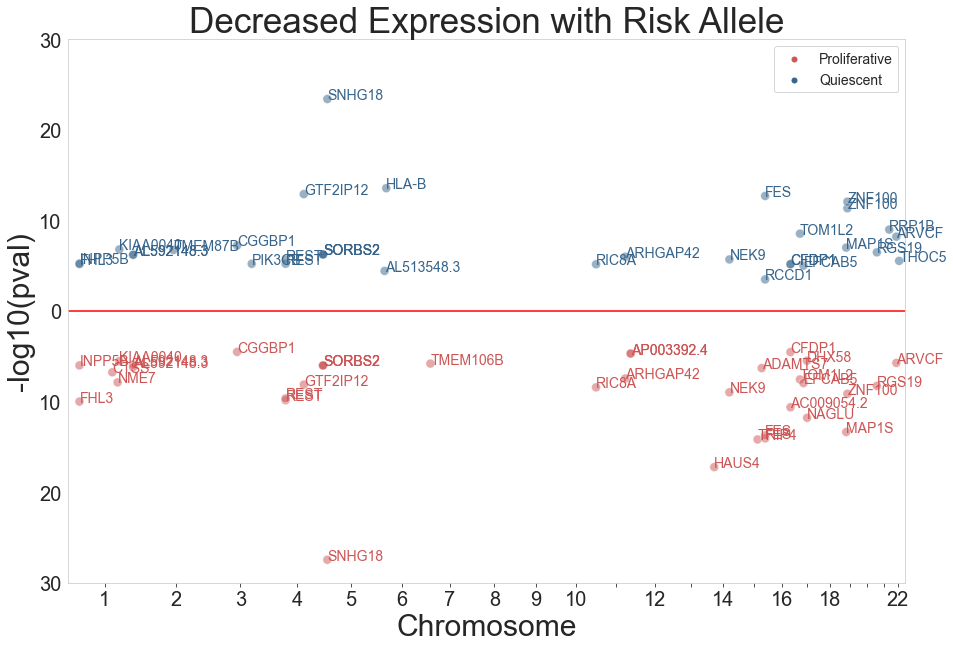

In [14]:
make_plot(df1, 'Decreased Expression with Risk Allele')

<ipython-input-12-dd3c832a75c4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
<ipython-input-12-dd3c832a75c4>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(pval)'] = df.apply(get_padj, axis = 1)


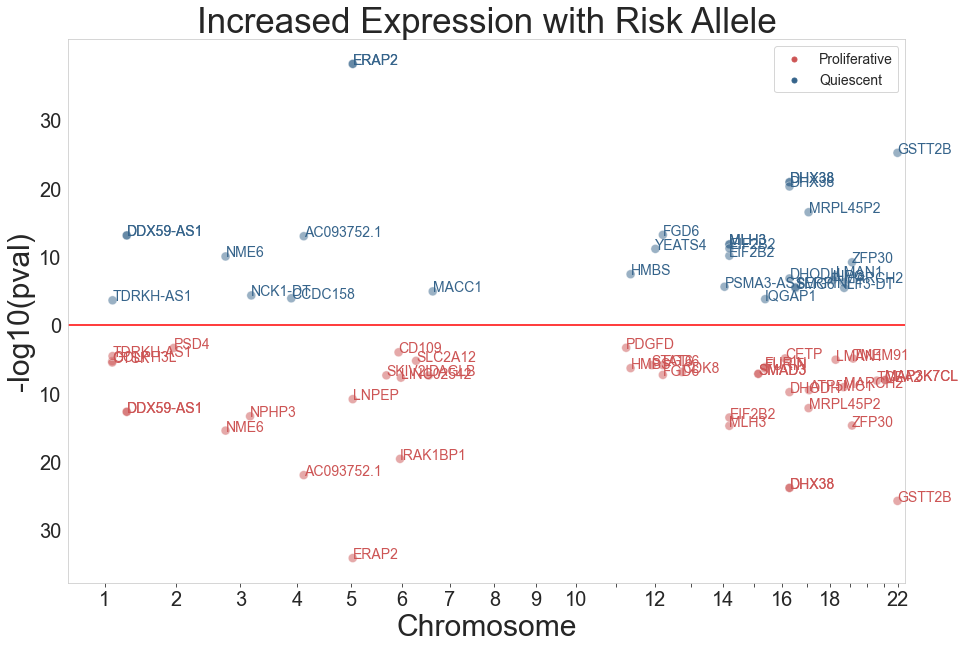

In [14]:
make_plot(df2, 'Increased Expression with Risk Allele')

In [15]:
df.to_csv('/scratch/dyl3pc/fastqtl/scripts/plots/images/input_list_eQTL.tsv', sep='\t', index=False)

In [45]:
def remove_duplicates(df):
    min_pval = min(df['pval_nominal'])
    df = df[df['pval_nominal'] == min_pval]
    chr_ = df.iloc[0]['chr']
    pos = df.iloc[0]['pos']
    increase_decrease_risk_allele = df.iloc[0]['increase_decrease_risk_allele']
    slope = df.iloc[0]['slope']
    return pd.Series([min_pval, chr_, pos, increase_decrease_risk_allele, slope])
df_min_pval = df.groupby(['chr_gene_name', 'Condition']).apply(remove_duplicates)
df_min_pval.columns = ['pval_nominal', 'chr', 'pos', 'increase_decrease_risk_allele', 'slope']
df_min_pval = pd.DataFrame(df_min_pval).reset_index()

In [46]:
def make_plot2(df, title, color):
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (15,10)
    plt.rcParams["axes.titlesize"] = 35
    plt.rcParams["axes.labelsize"] = 30
    plt.rcParams["xtick.labelsize"] = 20
    plt.rcParams["ytick.labelsize"] = 20
    plt.rcParams["lines.markersize"] = 5
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['legend.fontsize'] = 14


    chr_lengths = genome_annotations.get_chr_lengths()
    df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
    def get_padj(e):
        return  -1 * np.log10(e['pval_nominal'])
    df['-log10(pval)'] = df.apply(get_padj, axis = 1)
    df['slope'] = df.apply(lambda s: abs(s['slope']) if s['increase_decrease_risk_allele'] == 'Increased Expression with Risk Allele' else -1*abs(s['slope']), axis=1)
    df['marker'] = df['slope'].apply(lambda e: 'Increased Expression with Risk Allele' if e>0 else 'Decreased Expression with Risk Allele')
    # Create an array with the colors you want to use
    colors = [color]
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))

    ax = sns.scatterplot(data = df,
                         x = 'genome_wide_pos',
                         y = 'slope',
#                          size = '-log10(pval)',
                         alpha = 1,
                         style='marker',
                         markers={'Increased Expression with Risk Allele':'^',
                                 'Decreased Expression with Risk Allele':'v'},
#                          hue = "Condition",
                         s=80,
                        sizes=(100, 500))
    chr_labels_to_remove = [21,20,19, 17, 15, 13, 11]
    chr_nums = list(chr_lengths["chr_num"])
    for label in chr_labels_to_remove:
        chr_nums[label - 1] = ""
    plt.xticks(list(chr_lengths["cum_length"] + chr_lengths["length"]/2), chr_nums)
#     plt.xlabel("Chromosome")
#     plt.ylabel('Effect Size')
#     plt.title(title)
    plt.xlabel("")
    plt.ylabel('')
    plt.title('')

#     plt.yticks([-30,-20,-10,0,10,20,30],
#                ['30','20','10','0','10','20','30'])

    # new_labels = []
    for i in range(df.shape[0]):
        s = df.iloc[i]
        txt = s['chr_gene_name']
        if pd.isna(txt):
            txt = s["phenotype_id"]
        x = s["genome_wide_pos"]
        y = s["slope"]
        if txt in bolded_genes:
            weight='extra bold'
            fontsize=15
        else:
            weight='normal'
            fontsize=14
        if s['Condition'] == "Proliferative":
            plt.annotate(txt, (x, y), fontsize=fontsize, color=proliferative_color, weight=weight)
        else:
            plt.annotate(txt, (x, y), fontsize=fontsize, color=quiescent_color, weight=weight)

    # ax.get_legend().remove()
    plt.axhline(y=0, color=color, linestyle='solid')
    # plt.axhline(y=8, color='r', linestyle='dashed')
    ax.set_xlim(0, 2829728720 + 51304566)
    ax.grid(False)
    
    legend = ax.legend()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles[::-1], labels[::-1], loc='lower right')

    plt.savefig(save_location.format('_'.join(title.split(' '))))

In [47]:
df1 = df_min_pval[df_min_pval['Condition'] == "Quiescent"]
df2 = df_min_pval[df_min_pval['Condition'] == "Proliferative"]
quiescent_color = "#36648b"
proliferative_color = "#cd5555"
bolded_genes = set(df1['chr_gene_name']).intersection(set(df2['chr_gene_name']))

<ipython-input-17-9f20f683ea17>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
<ipython-input-17-9f20f683ea17>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(pval)'] = df.apply(get_padj, axis = 1)
<ipython-input-17-9f20f683ea17>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

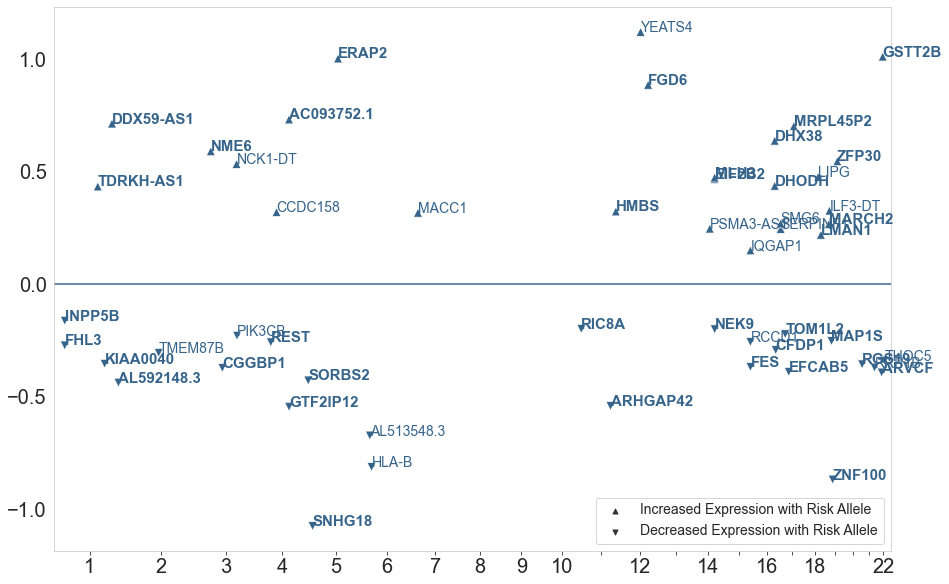

In [19]:
make_plot2(df1,'Quiescent',quiescent_color)

<ipython-input-17-9f20f683ea17>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
<ipython-input-17-9f20f683ea17>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(pval)'] = df.apply(get_padj, axis = 1)
<ipython-input-17-9f20f683ea17>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

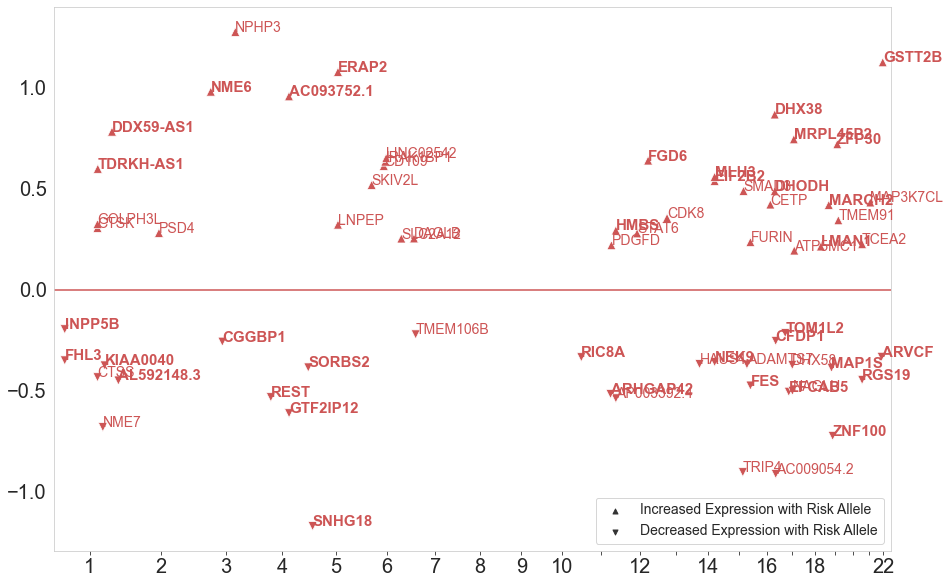

In [20]:
make_plot2(df2,'Proliferative',proliferative_color)

In [136]:
def make_plot3(df, title, color, bolded_genes):
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (15,10)
    plt.rcParams["axes.titlesize"] = 35
    plt.rcParams["axes.labelsize"] = 30
    plt.rcParams["xtick.labelsize"] = 20
    plt.rcParams["ytick.labelsize"] = 20
    plt.rcParams["lines.markersize"] = 5
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['legend.fontsize'] = 14


    chr_lengths = genome_annotations.get_chr_lengths()
    df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
    def get_padj(e):
        return  -1 * np.log10(e['pval_nominal'])
    df['-log10(pval)'] = df.apply(get_padj, axis = 1)
    df['slope'] = df.apply(lambda s: abs(s['slope']) if s['increase_decrease_risk_allele'] == 'Increased Expression with Risk Allele' else -1*abs(s['slope']), axis=1)
    df['marker'] = df['slope'].apply(lambda e: 'Increased Expression with Risk Allele' if e>0 else 'Decreased Expression with Risk Allele')
    # Create an array with the colors you want to use
    colors = [proliferative_color, quiescent_color]
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))
    df['color'] = df['slope'].apply(lambda e: 'positive' if e > 0 else 'negative')
    ax = sns.scatterplot(data = df,
                         x = 'genome_wide_pos',
                         y = 'slope',
#                          size = '-log10(pval)',
                         alpha = 1,
                         style='marker',
                         markers={'Increased Expression with Risk Allele':'^',
                                 'Decreased Expression with Risk Allele':'v'},
                         hue='color',
#                          hue = "Condition",
                         s=80,
                        sizes=(100, 500))
    chr_labels_to_remove = [21,20,19, 17, 15, 13, 11]
    chr_nums = list(chr_lengths["chr_num"])
    for label in chr_labels_to_remove:
        chr_nums[label - 1] = ""
    plt.xticks(list(chr_lengths["cum_length"] + chr_lengths["length"]/2), chr_nums)
#     plt.xlabel("Chromosome")
#     plt.ylabel('Effect Size')
#     plt.title(title)
    plt.xlabel("")
    plt.ylabel('')
    plt.title('')

#     plt.yticks([-30,-20,-10,0,10,20,30],
#                ['30','20','10','0','10','20','30'])

    # new_labels = []
    for i in range(df.shape[0]):
        s = df.iloc[i]
        txt = s['chr_gene_name']
        if pd.isna(txt):
            txt = s["phenotype_id"]
        x = s["genome_wide_pos"]
        y = s["slope"]
        if txt in bolded_genes:
            weight='bold'
            fontsize=15
        else:
            weight='normal'
            fontsize=14
        if txt == 'AL592148.3':
            txt = 'MIA3-AS1'
        if s['slope'] > 0:
            plt.annotate(txt, (x, y), fontsize=fontsize, color=proliferative_color, weight=weight)
        else:
            plt.annotate(txt, (x, y), fontsize=fontsize, color=quiescent_color, weight=weight)

    # ax.get_legend().remove()
    plt.axhline(y=0, color=color, linestyle='solid')
    # plt.axhline(y=8, color='r', linestyle='dashed')
    ax.set_xlim(0, 2829728720 + 51304566)
    ax.grid(False)
    
    legend = ax.legend()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles[::-1], labels[::-1], loc='lower right')
    ax.get_legend().remove()
    save_location2 = save_location.format('_'.join(title.split(' ')))
    print(save_location2)
    plt.savefig(save_location2)

In [129]:
df1

,chr_gene_name,Condition,pval_nominal,chr,pos,increase_decrease_risk_allele,slope,genome_wide_pos,-log10(pval),marker,color
2,AC093752.1,Quiescent,1.084294e-13,chr4,119502325,Increased Expression with Risk Allele,0.732879,809974749,12.964853,Increased Expression with Risk Allele,positive
4,AL513548.3,Quiescent,3.850469e-05,chr6,25615119,Decreased Expression with Risk Allele,-0.671916,1088157079,4.414486,Decreased Expression with Risk Allele,negative
6,AL592148.3,Quiescent,6.324514e-07,chr1,222708030,Decreased Expression with Risk Allele,-0.436938,222708030,6.198973,Decreased Expression with Risk Allele,negative
9,ARHGAP42,Quiescent,1.045871e-06,chr11,100687254,Decreased Expression with Risk Allele,-0.540623,1916595144,5.980522,Decreased Expression with Risk Allele,negative
11,ARVCF,Quiescent,6.342262e-09,chr22,19972661,Decreased Expression with Risk Allele,-0.391760,2849701381,8.197756,Decreased Expression with Risk Allele,negative
13,CCDC158,Quiescent,1.305430e-04,chr4,76499254,Increased Expression with Risk Allele,0.321321,766971678,3.884247,Increased Expression with Risk Allele,positive
18,CFDP1,Quiescent,6.917484e-06,chr16,75436678,Decreased Expression with Risk Allele,-0.292163,2485253789,5.160052,Decreased Expression with Risk Allele,negative
20,CGGBP1,Quiescent,5.958330e-08,chr3,88054626,Decreased Expression with Risk Allele,-0.371151,580504620,7.224875,Decreased Expression with Risk Allele,negative
25,DDX59-AS1,Quiescent,8.316206e-14,chr1,200669534,Increased Expression with Risk Allele,0.714645,200669534,13.080075,Increased Expression with Risk Allele,positive
27,DHODH,Quiescent,1.647783e-07,chr16,72002678,Increased Expression with Risk Allele,0.438176,2481819789,6.783100,Increased Expression with Risk Allele,positive


In [130]:
df2

,chr_gene_name,Condition,pval_nominal,chr,pos,increase_decrease_risk_allele,slope,genome_wide_pos,-log10(pval),marker,color
0,AC009054.2,Proliferative,2.291674e-11,chr16,75400248,Decreased Expression with Risk Allele,-0.912047,2485217359,10.639847,Decreased Expression with Risk Allele,negative
1,AC093752.1,Proliferative,1.066931e-22,chr4,119373176,Increased Expression with Risk Allele,0.956484,809845600,21.971864,Increased Expression with Risk Allele,positive
3,ADAMTS7,Proliferative,4.838550e-07,chr15,78864641,Decreased Expression with Risk Allele,-0.369940,2386150360,6.315285,Decreased Expression with Risk Allele,negative
5,AL592148.3,Proliferative,5.931342e-07,chr1,222689650,Decreased Expression with Risk Allele,-0.449485,222689650,6.226847,Decreased Expression with Risk Allele,negative
7,AP003392.4,Proliferative,1.960330e-05,chr11,119074475,Decreased Expression with Risk Allele,-0.537657,1934982365,4.707671,Decreased Expression with Risk Allele,negative
...,...,...,...,...,...,...,...,...,...,...,...
111,TMEM91,Proliferative,1.183306e-05,chr19,41376807,Increased Expression with Risk Allele,0.343246,2700821129,4.926903,Increased Expression with Risk Allele,positive
112,TOM1L2,Proliferative,2.701927e-08,chr17,17829005,Decreased Expression with Risk Allele,-0.215068,2518000869,7.568326,Decreased Expression with Risk Allele,negative
114,TRIP4,Proliferative,6.409100e-15,chr15,64726327,Decreased Expression with Risk Allele,-0.903198,2372012046,14.193203,Decreased Expression with Risk Allele,negative
116,ZFP30,Proliferative,1.896308e-15,chr19,37726512,Increased Expression with Risk Allele,0.719402,2697170834,14.722091,Increased Expression with Risk Allele,positive


In [131]:
quiescent_color = "#36648b"
proliferative_color = "#cd5555"

In [132]:
df = pd.concat([df1, df2])
df = df.sort_values('-log10(pval)')
df = df.drop_duplicates(['chr_gene_name'])

In [133]:
proliferative_quiescent_intersection = set(df1['chr_gene_name']).intersection(set(df2['chr_gene_name']))

/scratch/dyl3pc/fastqtl/scripts/plots/images/manhattan_CAD_coloc_eQTL_All.svg


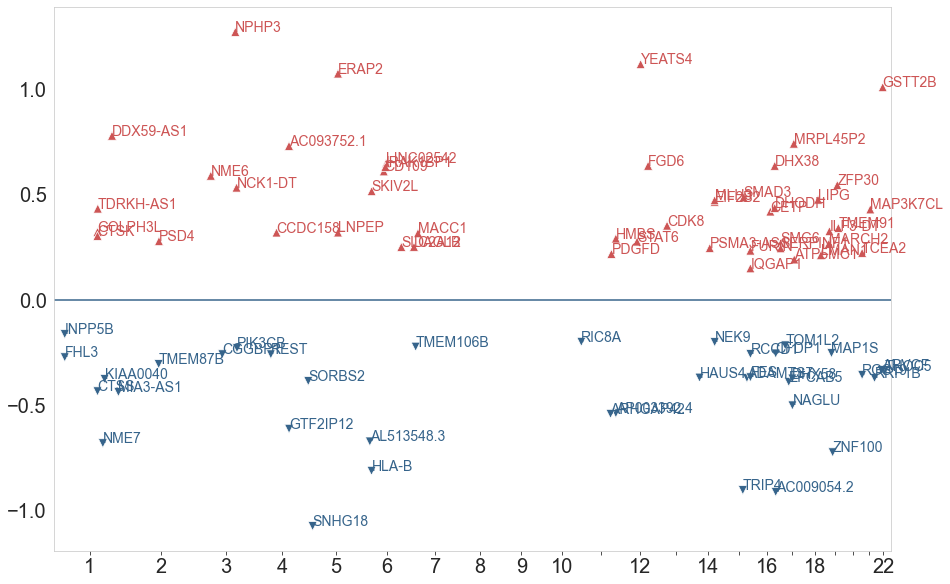

In [139]:
make_plot3(df,'All',quiescent_color, set())

/scratch/dyl3pc/fastqtl/scripts/plots/images/manhattan_CAD_coloc_eQTL_All.svg


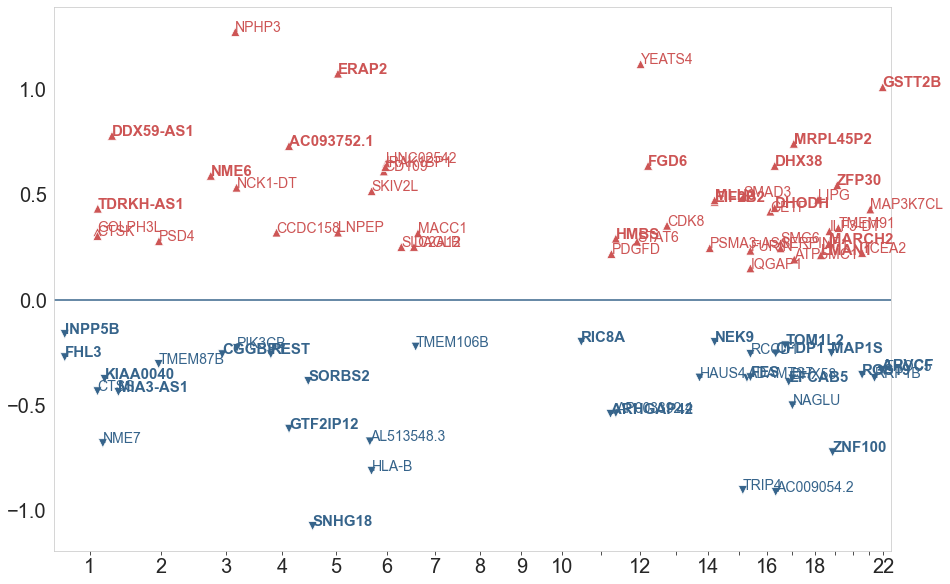

In [138]:
make_plot3(df,'All',quiescent_color, proliferative_quiescent_intersection)

<ipython-input-39-2284a89b7077>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
<ipython-input-39-2284a89b7077>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(pval)'] = df.apply(get_padj, axis = 1)
<ipython-input-39-2284a89b7077>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

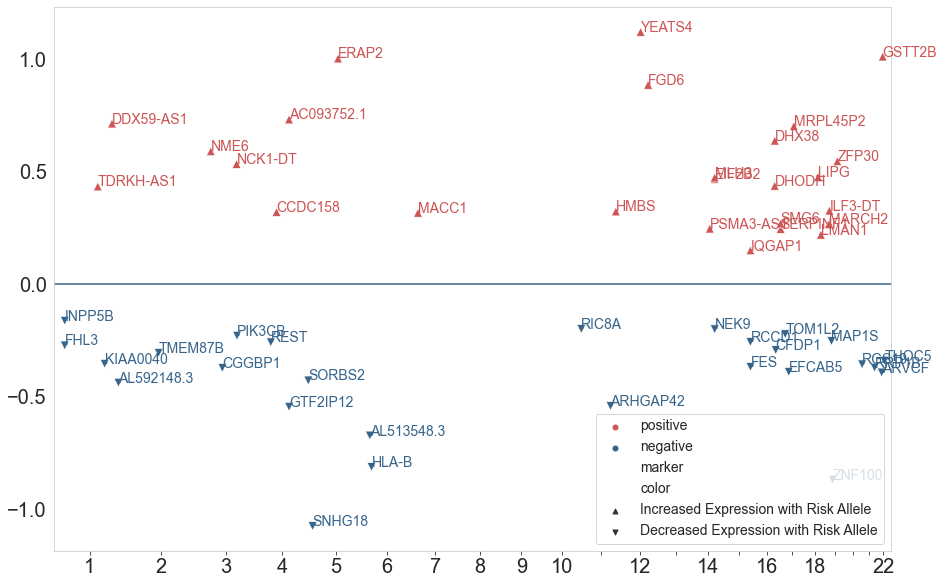

In [48]:
make_plot3(df1,'Quiescent',quiescent_color)

<ipython-input-39-2284a89b7077>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
<ipython-input-39-2284a89b7077>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(pval)'] = df.apply(get_padj, axis = 1)
<ipython-input-39-2284a89b7077>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

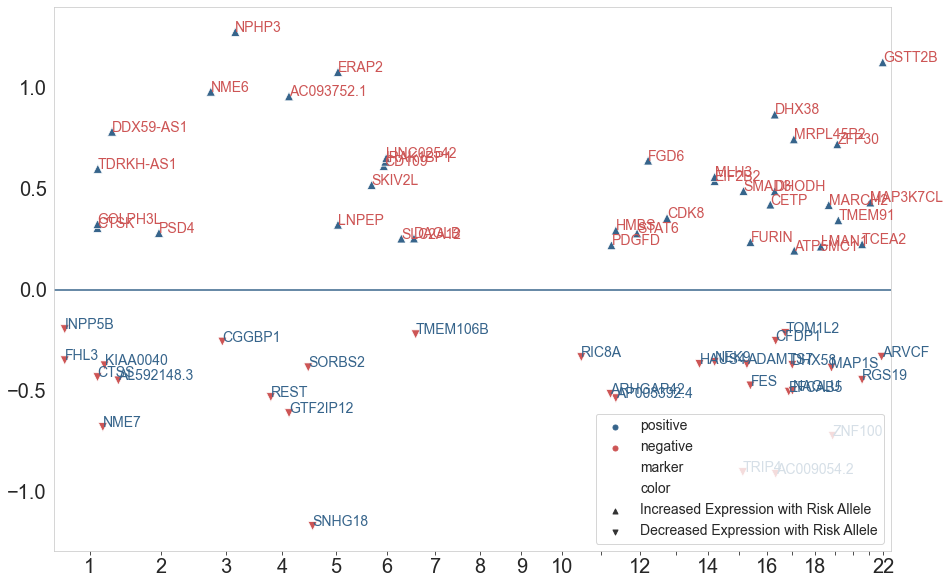

In [52]:
make_plot3(df2,'Proliferative',quiescent_color)

# sQTL

In [2]:
CAD_coloc = pd.read_csv('/scratch/dyl3pc/fastqtl/scripts/plots/data/CAD_coloc_sQTL.csv')

In [3]:
CAD_coloc['Condition'] = CAD_coloc['Condition'].apply(lambda e: 'Proliferative' if e == 'WithFBS' else 'Quiescent')

In [4]:
CAD_coloc.drop(columns=['Tools'],inplace=True)

In [5]:
CAD_coloc['gene_id_SNP'] = CAD_coloc.apply(lambda e: f"{e['gene_id']}_{e['SNP']}", axis=1)
CAD_coloc_WithFBS_gene_id_SNP = set(CAD_coloc[CAD_coloc['Condition'] == 'Proliferative']['gene_id_SNP'])
CAD_coloc_WithoutFBS_gene_id_SNP = set(CAD_coloc[CAD_coloc['Condition'] == 'Quiescent']['gene_id_SNP'])

In [6]:
df1_file_name = "/scratch/dyl3pc/fastqtl/data/sQTL/WithFBS/cis_QTL/best_num_covariates/allpairs_anno.txt.gz"
df2_file_name = "/scratch/dyl3pc/fastqtl/data/sQTL/WithoutFBS/cis_QTL/best_num_covariates/allpairs_anno.txt.gz"
save_location = '/scratch/dyl3pc/fastqtl/scripts/plots/images/manhattan_CAD_coloc_sQTL_{}.svg'

In [7]:
def filter_WithFBS_filter_funct(values_dict):
    return f"{values_dict['phenotype_id']}_{values_dict['variant_id']}" in CAD_coloc_WithFBS_gene_id_SNP
def filter_WithoutFBS_filter_funct(values_dict):
    return f"{values_dict['phenotype_id']}_{values_dict['variant_id']}" in CAD_coloc_WithoutFBS_gene_id_SNP
df = utils.read_large_csv(df1_file_name, filter_WithFBS_filter_funct, sep='\t')
df2 = utils.read_large_csv(df2_file_name, filter_WithoutFBS_filter_funct, sep='\t')
df['Condition'] = 'Proliferative'
df2['Condition'] = 'Quiescent'
df = df.append(df2)

In [8]:
GWAS_variant_risk_allele_dict = utils.get_GWAS_variant_risk_allele_dict('/scratch/dyl3pc/fastqtl/data/other_studies/CAD_GWAS_64/grch38_cleaned.sumstats')

In [47]:
df['GWAS_risk_allele'] = df['variant_id'].apply(lambda e: GWAS_variant_risk_allele_dict[e] if e in GWAS_variant_risk_allele_dict else "")

In [48]:
df = df[df['GWAS_risk_allele'] != '']

In [49]:
chr_lengths = genome_annotations.get_chr_lengths()

In [50]:
def get_increase_decrease_with_risk_allele(s):
    gwas_risk_allele = s['GWAS_risk_allele']
    eqtl_alt = s['alt']
    slope = s['slope']
    if eqtl_alt == gwas_risk_allele:
        if slope >= 0:
            return "Increased Expression with Risk Allele"
        else:
            return "Decreased Expression with Risk Allele"
    else:
        if slope >= 0:
            return "Decreased Expression with Risk Allele"
        else:
            return "Increased Expression with Risk Allele"
df['increase_decrease_risk_allele'] = df.apply(get_increase_decrease_with_risk_allele, axis = 1)

In [55]:
# this is to get the risk allele
df.to_csv('/scratch/dyl3pc/fastqtl/scripts/plots/images/input_list_sQTL.tsv', sep='\t', index=False)

,phenotype_id,variant_id,tss_distance,maf,ma_samples,ma_count,pval_nominal,slope,slope_se,chr_gene_name,chr,pos,rsid,ref,alt,Condition,GWAS_risk_allele,increase_decrease_risk_allele,genome_wide_pos,-log10(pval)
0,1:3402992:3404739:clu_12209_+:ENSG00000142611.17,rs2493288,9581,0.144828,39,42,7.877675e-05,-0.597427,0.146584,PRDM16,chr1,3414320,rs2493288,G,A,Proliferative,A,Decreased Expression with Risk Allele,3414320,-4.103602
1,1:113706701:113710254:clu_5891_-:ENSG000001167...,rs1230642,12615,0.313793,74,91,6.202832e-05,0.402416,0.097249,PHTF1,chr1,113722869,rs1230642,A,G,Proliferative,G,Increased Expression with Risk Allele,113722869,-4.207410
2,1:113905775:113908009:clu_13680_+:ENSG00000118...,rs2358995,-21116,0.272414,65,79,2.018825e-11,-0.945397,0.128906,DCLRE1B,chr1,113886893,rs2358995,A,C,Proliferative,C,Decreased Expression with Risk Allele,113886893,-10.694901
3,1:113905775:113908009:clu_13680_+:ENSG00000118...,rs7547478,-19168,0.272414,65,79,2.018825e-11,-0.945397,0.128906,DCLRE1B,chr1,113888841,rs7547478,G,A,Proliferative,A,Decreased Expression with Risk Allele,113888841,-10.694901
4,1:113907161:113908009:clu_13680_+:ENSG00000118...,rs3761936,-969,0.268966,64,78,4.868093e-06,0.686495,0.144012,DCLRE1B,chr1,113907040,rs3761936,T,C,Proliferative,C,Increased Expression with Risk Allele,113907040,-5.312641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,22:29529239:29531078:clu_20431_-:ENSG000001002...,rs2302141,-1783,0.212230,55,59,1.578084e-30,-1.719413,0.112882,THOC5,chr22,29529295,rs2302141,T,C,Quiescent,C,Decreased Expression with Risk Allele,2859258015,29.801870
218,22:29529239:29531831:clu_20431_-:ENSG000001002...,rs2302141,-2536,0.212230,55,59,3.908202e-29,1.650689,0.112713,THOC5,chr22,29529295,rs2302141,T,C,Quiescent,C,Increased Expression with Risk Allele,2859258015,28.408023
219,22:29531110:29531831:clu_20431_-:ENSG000001002...,rs2302141,-2536,0.212230,55,59,1.887042e-31,-1.792982,0.114758,THOC5,chr22,29529295,rs2302141,T,C,Quiescent,C,Decreased Expression with Risk Allele,2859258015,30.724218
220,22:40301005:40301150:clu_56960_+:ENSG000001003...,rs5750913,-56869,0.219424,54,61,2.427567e-14,-1.293238,0.150382,TNRC6B,chr22,40244281,rs5750913,A,G,Quiescent,G,Decreased Expression with Risk Allele,2869973001,13.614829


In [98]:
df

,phenotype_id,variant_id,tss_distance,maf,ma_samples,ma_count,pval_nominal,slope,slope_se,chr_gene_name,chr,pos,rsid,ref,alt,Condition,GWAS_risk_allele,increase_decrease_risk_allele,genome_wide_pos,-log10(pval)
0,1:3402992:3404739:clu_12209_+:ENSG00000142611.17,rs2493288,9581,0.144828,39,42,7.877675e-05,-0.597427,0.146584,PRDM16,chr1,3414320,rs2493288,G,A,Proliferative,A,Decreased Expression with Risk Allele,3414320,-4.103602
1,1:113706701:113710254:clu_5891_-:ENSG000001167...,rs1230642,12615,0.313793,74,91,6.202832e-05,0.402416,0.097249,PHTF1,chr1,113722869,rs1230642,A,G,Proliferative,G,Increased Expression with Risk Allele,113722869,-4.207410
2,1:113905775:113908009:clu_13680_+:ENSG00000118...,rs2358995,-21116,0.272414,65,79,2.018825e-11,-0.945397,0.128906,DCLRE1B,chr1,113886893,rs2358995,A,C,Proliferative,C,Decreased Expression with Risk Allele,113886893,-10.694901
3,1:113905775:113908009:clu_13680_+:ENSG00000118...,rs7547478,-19168,0.272414,65,79,2.018825e-11,-0.945397,0.128906,DCLRE1B,chr1,113888841,rs7547478,G,A,Proliferative,A,Decreased Expression with Risk Allele,113888841,-10.694901
4,1:113907161:113908009:clu_13680_+:ENSG00000118...,rs3761936,-969,0.268966,64,78,4.868093e-06,0.686495,0.144012,DCLRE1B,chr1,113907040,rs3761936,T,C,Proliferative,C,Increased Expression with Risk Allele,113907040,-5.312641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,22:29529239:29531078:clu_20431_-:ENSG000001002...,rs2302141,-1783,0.212230,55,59,1.578084e-30,-1.719413,0.112882,THOC5,chr22,29529295,rs2302141,T,C,Quiescent,C,Decreased Expression with Risk Allele,2859258015,29.801870
218,22:29529239:29531831:clu_20431_-:ENSG000001002...,rs2302141,-2536,0.212230,55,59,3.908202e-29,1.650689,0.112713,THOC5,chr22,29529295,rs2302141,T,C,Quiescent,C,Increased Expression with Risk Allele,2859258015,28.408023
219,22:29531110:29531831:clu_20431_-:ENSG000001002...,rs2302141,-2536,0.212230,55,59,1.887042e-31,-1.792982,0.114758,THOC5,chr22,29529295,rs2302141,T,C,Quiescent,C,Decreased Expression with Risk Allele,2859258015,30.724218
220,22:40301005:40301150:clu_56960_+:ENSG000001003...,rs5750913,-56869,0.219424,54,61,2.427567e-14,-1.293238,0.150382,TNRC6B,chr22,40244281,rs5750913,A,G,Quiescent,G,Decreased Expression with Risk Allele,2869973001,13.614829


In [99]:
def test(df):
    min_pval = min(df['pval_nominal'])
    df = df[df['pval_nominal'] == min_pval]
    chr_ = df.iloc[0]['chr']
    pos = df.iloc[0]['pos']
    return pd.Series([min_pval, chr_, pos])
df_min_pval = df.groupby(['chr_gene_name', 'Condition']).apply(test)

In [101]:
df_min_pval.columns = ['pval_nominal', 'chr', 'pos']

In [102]:
df_min_pval = pd.DataFrame(df_min_pval).reset_index()

In [105]:
def make_plot(df, title):
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (15,10)
    plt.rcParams["axes.titlesize"] = 35
    plt.rcParams["axes.labelsize"] = 30
    plt.rcParams["xtick.labelsize"] = 20
    plt.rcParams["ytick.labelsize"] = 20
    plt.rcParams["lines.markersize"] = 5
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['legend.fontsize'] = 14

    quiescent_color = "#36648b"
    proliferative_color = "#cd5555"

    chr_lengths = genome_annotations.get_chr_lengths()
    df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
    def get_padj(e):
        if e['Condition'] == "Quiescent":
            return -1 * np.log10(e['pval_nominal'])
        else:
            return 1 * np.log10(e['pval_nominal'])
    #     df = df[df['qval'] <= 0.05]
    df['-log10(pval)'] = df.apply(get_padj, axis = 1)

    # Create an array with the colors you want to use
    colors = [proliferative_color, quiescent_color]
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))

    ax = sns.scatterplot(data = df,
                         x = 'genome_wide_pos',
                         y = '-log10(pval)',
                         alpha = 0.5,
                         hue = "Condition",
                         s=80)
    chr_labels_to_remove = [21,20,19, 17, 15, 13, 11]
    chr_nums = list(chr_lengths["chr_num"])
    for label in chr_labels_to_remove:
        chr_nums[label - 1] = ""
    plt.xticks(list(chr_lengths["cum_length"] + chr_lengths["length"]/2), chr_nums)
    plt.xlabel("Chromosome")
    plt.yticks([-30,-20,-10,0,10,20,30],
               ['30','20','10','0','10','20','30'])

    # new_labels = []
    for i in range(df.shape[0]):
        s = df.iloc[i]
        txt = s['chr_gene_name']
        if pd.isna(txt):
            txt = s["phenotype_id"]
        x = s["genome_wide_pos"]
        y = s["-log10(pval)"]
        if s['Condition'] == "Proliferative":
            plt.annotate(txt, (x, y), fontsize=14, color=proliferative_color)
        else:
            plt.annotate(txt, (x, y), fontsize=14, color=quiescent_color)
    # ax.get_legend().remove()
    plt.axhline(y=0, color='r', linestyle='solid')
    # plt.axhline(y=8, color='r', linestyle='dashed')
    ax.set_xlim(0, 2829728720 + 51304566)
    ax.grid(False)
    legend = ax.legend()
    plt.savefig(save_location.format('_'.join(title.split(' '))))
    plt.title(title)

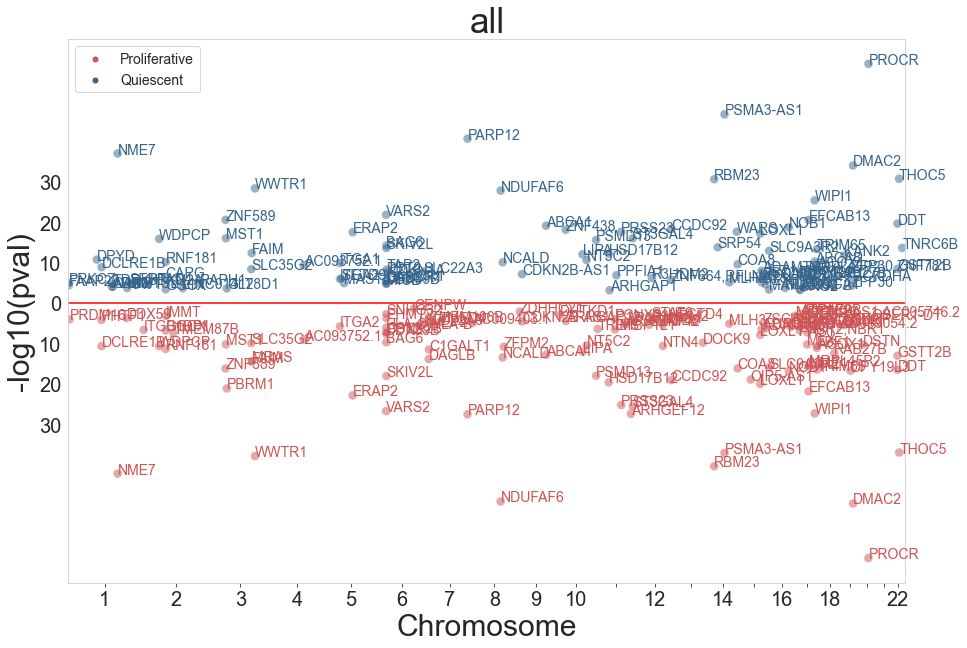

In [106]:
make_plot(df_min_pval, 'all')

In [12]:
df = pd.read_csv('/scratch/dyl3pc/fastqtl/data/correct_GWAS_sumstats/gwas_catalog_raw/CAD.tsv.gz', sep='\t')

In [16]:
GWAS_variant_risk_allele_dict['rs62011052']

'C'

In [17]:
GWAS_variant_risk_allele_dict['rs2832227']

'G'

In [19]:
"""
Lead MAP3K7CL: rs2832227
GWAS catalog: A
T2D: G
My calculation: G
"""
df[df['hm_rsid'] == 'rs2832227'].iloc[0][['effect_allele', 'other_allele', 'beta']]

effect_allele         a
other_allele          g
beta            -0.0393
Name: 3657333, dtype: object

In [21]:
"""
MAP3K7CL: rs8128235
Redouane lead SNP: T
my calculation: C
"""
df[df['hm_rsid'] == 'rs8128235'].iloc[0][['effect_allele', 'other_allele', 'beta']]

effect_allele         t
other_allele          c
beta            -0.0423
Name: 3657458, dtype: object

In [22]:
"""
ADAMTS7
my calculation: C
Redouane calcualtion: C
GWAS catalog: not found
T2D: C
"""
df[df['hm_rsid'] == 'rs62011052'].iloc[0][['effect_allele', 'other_allele', 'beta']]

effect_allele         t
other_allele          c
beta            -0.0553
Name: 1906732, dtype: object

In [24]:
"""
AL592148.3
my calculation: C
Redouane calcualtion: C
GWAS catalog: maybe C, A
T2D: C
"""
df[df['hm_rsid'] == 'rs17465637'].iloc[0][['effect_allele', 'other_allele', 'beta']]

effect_allele         a
other_allele          c
beta            -0.0696
Name: 3118011, dtype: object

In [ ]:
"""
MLH3: rs3832966
my calculation: C
Redouane calcualtion: C
GWAS catalog: maybe C, A
T2D: C
"""
df[df['hm_rsid'] == 'rs17465637'].iloc[0][['effect_allele', 'other_allele', 'beta']]

# Mete Grant

In [134]:
df = pd.read_csv('/scratch/dyl3pc/mete_grant_plot/data.txt', sep='\t')

In [135]:
df_gene_names = pd.read_csv('/scratch/dyl3pc/mete_grant_plot/genes.txt', sep='\t')

In [136]:
gene_names = df_gene_names.set_index('SPLICE').to_dict()['GENE']

In [137]:
df['GENE'] = df['SPLICE'].apply(lambda e: gene_names[e] if e in gene_names else "")

In [138]:
df['abs_beta_gwas'] = df['BETA_GWAS'].apply(lambda e: abs(e))

In [139]:
df = df.sort_values('abs_beta_gwas', ascending=True)

In [140]:
df = df.drop_duplicates('GENE')

In [142]:
df['chr'] = df['SPLICE'].apply(lambda e: e.split(':')[0])
df['pos'] = df['SPLICE'].apply(lambda e: int(e.split(':')[1]))

In [143]:
df

,SPLICE,SNP,REF,ALT,BETA_sQTL,BETA_GWAS,GENE,abs_beta_gwas,chr,pos
61,chr20:33509669:33511126:clu_34100,rs2378335,T,A,0.323749,-0.0014,ACSS2,0.0014,chr20,33509669
15,chr12:56088754:56089306:clu_4807,rs6581079,G,A,0.276453,0.0080,ITGA7,0.0080,chr12,56088754
1,chr1:17287625:17292218:clu_57714,rs2273113,C,T,0.369640,-0.0094,CROCC,0.0094,chr1,17287625
75,chr6:33385472:33385864:clu_40312,rs211474,G,A,-0.016602,-0.0097,CUTA,0.0097,chr6,33385472
26,chr15:41770823:41771301:clu_21867,rs66593163,C,T,0.144894,0.0102,RTF1,0.0102,chr15,41770823
76,chr9:131568590:131570093:clu_65515,rs1572912,C,T,0.368989,-0.0104,"TBC1D13,ENDOG",0.0104,chr9,131568590
30,chr16:426455:426544:clu_18061,rs11641742,G,A,-0.533727,0.0105,TMEM8A,0.0105,chr16,426455
0,chr1:17215280:17216043:clu_57705,rs6691985,C,T,-0.370995,-0.0106,RP11-108M9.4,0.0106,chr1,17215280
31,chr16:1362604:1364021:clu_18267,rs75893715,C,T,-0.332524,0.0107,UBE2I,0.0107,chr16,1362604
59,chr2:219101456:219103387:clu_55984,rs3731861,C,T,-0.470807,-0.0112,ARPC2,0.0112,chr2,219101456


In [144]:
def get_increase_decrease_with_risk_allele(s):
    if s['BETA_sQTL'] * s['BETA_GWAS'] > 0:
        return "Increased Expression with Risk Allele"
    else:
        return "Decreased Expression with Risk Allele"
df['increase_decrease_risk_allele'] = df.apply(get_increase_decrease_with_risk_allele, axis = 1)

In [149]:
def make_plot3(df, title, color, bolded_genes):
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (15,10)
    plt.rcParams["axes.titlesize"] = 35
    plt.rcParams["axes.labelsize"] = 30
    plt.rcParams["xtick.labelsize"] = 20
    plt.rcParams["ytick.labelsize"] = 20
    plt.rcParams["lines.markersize"] = 5
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['legend.fontsize'] = 14
    quiescent_color = "#36648b"
    proliferative_color = "#cd5555"



    chr_lengths = genome_annotations.get_chr_lengths()
    df['genome_wide_pos'] = df.apply(lambda s: utils.get_genome_wide_pos(s['chr'], s['pos']), axis=1)
    def get_padj(e):
        return  -1 * np.log10(e['pval_nominal'])
    df['slope'] = df.apply(lambda s: abs(s['BETA_sQTL']) if s['increase_decrease_risk_allele'] == 'Increased Expression with Risk Allele' else -1*abs(s['BETA_sQTL']), axis=1)
    df['marker'] = df['slope'].apply(lambda e: 'Increased Expression with Risk Allele' if e>0 else 'Decreased Expression with Risk Allele')
    # Create an array with the colors you want to use
    colors = [quiescent_color, proliferative_color]
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))
#     df['color'] = df['slope'].apply(lambda e: 'positive' if e > 0 else 'negative')
    ax = sns.scatterplot(data = df,
                         x = 'genome_wide_pos',
                         y = 'slope',
#                          size = '-log10(pval)',
                         alpha = 1,
                         style='marker',
                         markers={'Increased Expression with Risk Allele':'^',
                                 'Decreased Expression with Risk Allele':'v'},
#                          hue = "Condition",
                         s=80,
                        sizes=(100, 500))
    chr_labels_to_remove = [21,20,19, 17, 15, 13, 11]
    chr_nums = list(chr_lengths["chr_num"])
    for label in chr_labels_to_remove:
        chr_nums[label - 1] = ""
    plt.xticks(list(chr_lengths["cum_length"] + chr_lengths["length"]/2), chr_nums)
#     plt.xlabel("Chromosome")
#     plt.ylabel('Effect Size')
#     plt.title(title)
    plt.xlabel("")
    plt.ylabel('')
    plt.title('')

#     plt.yticks([-30,-20,-10,0,10,20,30],
#                ['30','20','10','0','10','20','30'])

    # new_labels = []
    for i in range(df.shape[0]):
        s = df.iloc[i]
        txt = s['GENE']
        if pd.isna(txt):
            txt = s["phenotype_id"]
        x = s["genome_wide_pos"]
        y = s["slope"]
        if txt in bolded_genes:
            weight='bold'
            fontsize=15
        else:
            weight='normal'
            fontsize=14
        if txt == 'AL592148.3':
            txt = 'MIA3-AS1'
        plt.annotate(txt, (x, y), fontsize=fontsize, color=quiescent_color, weight=weight)
#         if s['slope'] > 0:
#             plt.annotate(txt, (x, y), fontsize=fontsize, color=proliferative_color, weight=weight)
#         else:
#             plt.annotate(txt, (x, y), fontsize=fontsize, color=quiescent_color, weight=weight)

    # ax.get_legend().remove()
    plt.axhline(y=0, color=color, linestyle='solid')
    # plt.axhline(y=8, color='r', linestyle='dashed')
    ax.set_xlim(0, 2829728720 + 51304566)
    ax.grid(False)
    
    legend = ax.legend()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles[::-1], labels[::-1], loc='lower right')
#     ax.get_legend().remove()
#     save_location2 = save_location.format('_'.join(title.split(' ')))
#     print(save_location2)
    plt.xlabel('Chromosome')
    plt.ylabel('Effect Size sQTL')
    plt.savefig('/scratch/dyl3pc/mete_grant_plot/plot.png')

In [146]:
df

,SPLICE,SNP,REF,ALT,BETA_sQTL,BETA_GWAS,GENE,abs_beta_gwas,chr,pos,increase_decrease_risk_allele
61,chr20:33509669:33511126:clu_34100,rs2378335,T,A,0.323749,-0.0014,ACSS2,0.0014,chr20,33509669,Decreased Expression with Risk Allele
15,chr12:56088754:56089306:clu_4807,rs6581079,G,A,0.276453,0.0080,ITGA7,0.0080,chr12,56088754,Increased Expression with Risk Allele
1,chr1:17287625:17292218:clu_57714,rs2273113,C,T,0.369640,-0.0094,CROCC,0.0094,chr1,17287625,Decreased Expression with Risk Allele
75,chr6:33385472:33385864:clu_40312,rs211474,G,A,-0.016602,-0.0097,CUTA,0.0097,chr6,33385472,Increased Expression with Risk Allele
26,chr15:41770823:41771301:clu_21867,rs66593163,C,T,0.144894,0.0102,RTF1,0.0102,chr15,41770823,Increased Expression with Risk Allele
76,chr9:131568590:131570093:clu_65515,rs1572912,C,T,0.368989,-0.0104,"TBC1D13,ENDOG",0.0104,chr9,131568590,Decreased Expression with Risk Allele
30,chr16:426455:426544:clu_18061,rs11641742,G,A,-0.533727,0.0105,TMEM8A,0.0105,chr16,426455,Decreased Expression with Risk Allele
0,chr1:17215280:17216043:clu_57705,rs6691985,C,T,-0.370995,-0.0106,RP11-108M9.4,0.0106,chr1,17215280,Increased Expression with Risk Allele
31,chr16:1362604:1364021:clu_18267,rs75893715,C,T,-0.332524,0.0107,UBE2I,0.0107,chr16,1362604,Decreased Expression with Risk Allele
59,chr2:219101456:219103387:clu_55984,rs3731861,C,T,-0.470807,-0.0112,ARPC2,0.0112,chr2,219101456,Increased Expression with Risk Allele


In [148]:
df

,SPLICE,SNP,REF,ALT,BETA_sQTL,BETA_GWAS,GENE,abs_beta_gwas,chr,pos,increase_decrease_risk_allele,genome_wide_pos,slope,marker
61,chr20:33509669:33511126:clu_34100,rs2378335,T,A,0.323749,-0.0014,ACSS2,0.0014,chr20,33509669,Decreased Expression with Risk Allele,2752082974,-0.323749,Decreased Expression with Risk Allele
15,chr12:56088754:56089306:clu_4807,rs6581079,G,A,0.276453,0.0080,ITGA7,0.0080,chr12,56088754,Increased Expression with Risk Allele,2007003160,0.276453,Increased Expression with Risk Allele
1,chr1:17287625:17292218:clu_57714,rs2273113,C,T,0.369640,-0.0094,CROCC,0.0094,chr1,17287625,Decreased Expression with Risk Allele,17287625,-0.369640,Decreased Expression with Risk Allele
75,chr6:33385472:33385864:clu_40312,rs211474,G,A,-0.016602,-0.0097,CUTA,0.0097,chr6,33385472,Increased Expression with Risk Allele,1095927432,0.016602,Increased Expression with Risk Allele
26,chr15:41770823:41771301:clu_21867,rs66593163,C,T,0.144894,0.0102,RTF1,0.0102,chr15,41770823,Increased Expression with Risk Allele,2349056542,0.144894,Increased Expression with Risk Allele
76,chr9:131568590:131570093:clu_65515,rs1572912,C,T,0.368989,-0.0104,"TBC1D13,ENDOG",0.0104,chr9,131568590,Decreased Expression with Risk Allele,1670728302,-0.368989,Decreased Expression with Risk Allele
30,chr16:426455:426544:clu_18061,rs11641742,G,A,-0.533727,0.0105,TMEM8A,0.0105,chr16,426455,Decreased Expression with Risk Allele,2410243566,-0.533727,Decreased Expression with Risk Allele
0,chr1:17215280:17216043:clu_57705,rs6691985,C,T,-0.370995,-0.0106,RP11-108M9.4,0.0106,chr1,17215280,Increased Expression with Risk Allele,17215280,0.370995,Increased Expression with Risk Allele
31,chr16:1362604:1364021:clu_18267,rs75893715,C,T,-0.332524,0.0107,UBE2I,0.0107,chr16,1362604,Decreased Expression with Risk Allele,2411179715,-0.332524,Decreased Expression with Risk Allele
59,chr2:219101456:219103387:clu_55984,rs3731861,C,T,-0.470807,-0.0112,ARPC2,0.0112,chr2,219101456,Increased Expression with Risk Allele,468352077,0.470807,Increased Expression with Risk Allele


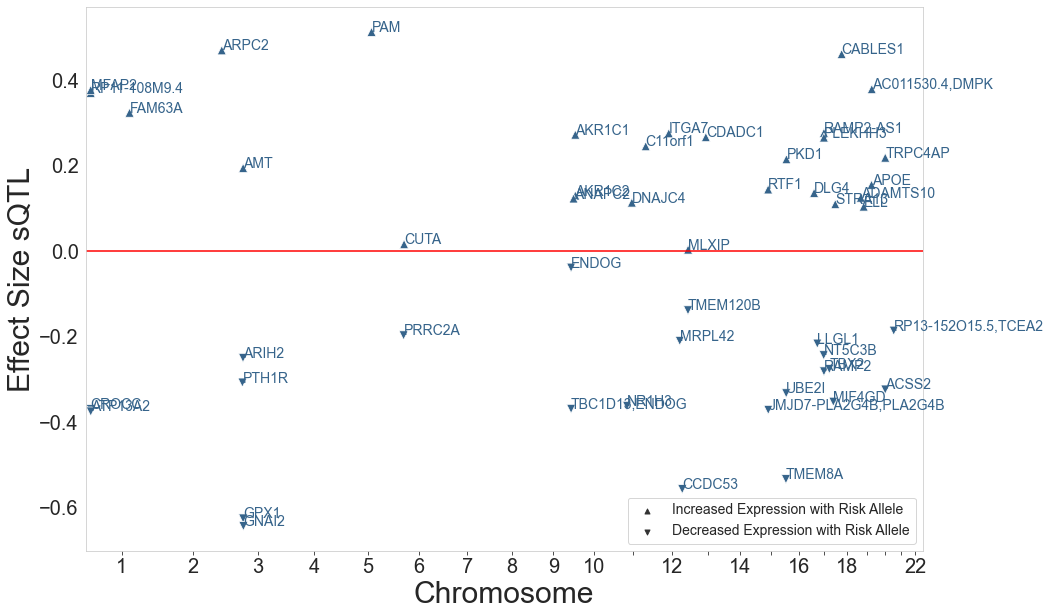

In [150]:
make_plot3(df, 'hello', 'red', set())